In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
from stan_models import save_pickle,load_pickle
import eis_utils as gt

%load_ext autoreload
%autoreload 2

# Load impedance data

For this example, we use impedance simulated from a circuit consisting of a ZARC element in series with an ohmic resistance. Random noise obeying J.R. Macdonald's proportional error model was added to the exact impedance.

In [2]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [3]:
# load simulated data
circuit = 'ZARC'
err_model = 'Macdonald'
noise_level = 1.0
Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))
# make complex impedance array
Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values
# load true drt
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

<IPython.core.display.Javascript object>


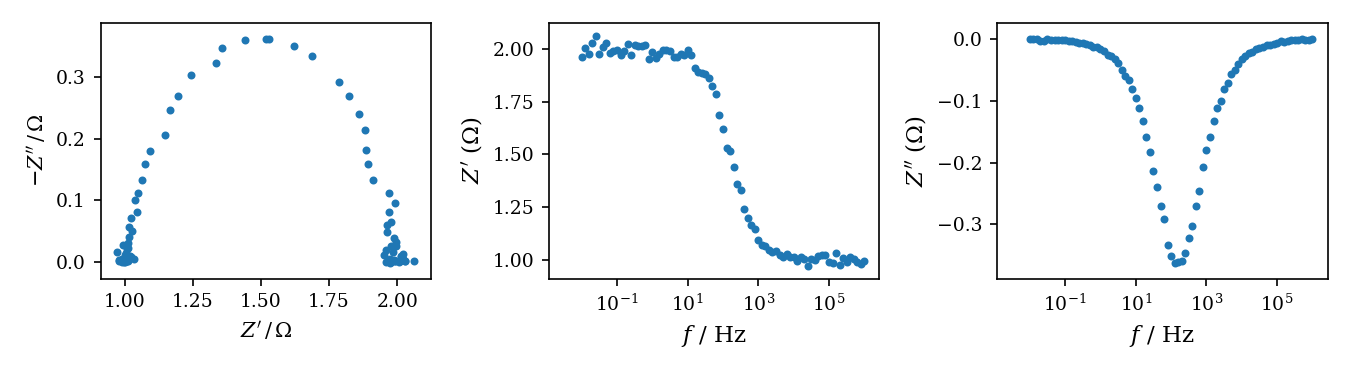

In [56]:
# plot the noisy impedance data
%matplotlib notebook
fig,axes = plt.subplots(1,3,figsize=(9,2.5))
gt.plot_full_eis(Zdf,axes=axes,bode_cols=['Zreal','Zimag'])
fig.tight_layout()

# Hyperparametric ridge fit

This is the method used to obtain initial parameter estimates for the hierarchical Bayesian model, as described in the Supplementary Information. Note that it is not necessary to provide initial parameter estimates; very similar solutions are obtained with and without initial estimates, but the initial estimates can increase the convergence speed of the hierarchical model in some cases. The hyperparametric ridge fit can be performed using the `ridge_fit` method of the `DRT` class.

In [21]:
# create DRT instance
dr_ridge = drt.DRT()

# run hyperparametric ridge fit using the recommended hyperparameter values
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (including matrix construction): {:.3f} s'.format(elapsed))

# re-run with precalculated matrices
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (without matrix construction): {:.3f} s'.format(elapsed))

Hyperparametric ridge fit time (including matrix construction): 7.243 s
Hyperparametric ridge fit time (without matrix construction): 0.052 s


The results of the fit can be accessed via the `DRT` object. The `drt` method returns the recovered DRT, while the `predict` method returns the fitted impedance, as shown in the plotting function defined below. When the solution is obtained via MCMC sampling, as in the next section, the `drt` method also takes an optional `percentile` argument, which can be used to generate credibility intervals.

In [57]:
def plot_drt_result(dr,Zdf,g_true,plot_ci=False):
    fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    freq = Zdf['Freq'].values
    
    # plot noisy data
    gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = dr.predict(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label='DRT fit',bode_cols=['Zreal','Zimag'],
                     c='k',plot_func='plot')

    # plot the true DRT
    axes[1,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
    # get the recovered DRT
    g_pred = dr.drt(g_true['tau'])
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if MCMC sampling used
        g_lo = dr.drt(g_true['tau'],percentile=2.5)
        g_hi = dr.drt(g_true['tau'],percentile=97.5)
        axes[1,1].plot(g_true['tau'],g_pred,c='k',label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(g_true['tau'],g_lo,g_hi,color='k',label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(g_true['tau'],g_pred,c='k',label='Recovered',alpha=0.8)
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \Omega$')

    for ax in axes.ravel():
        ax.legend()

    fig.tight_layout()

<IPython.core.display.Javascript object>


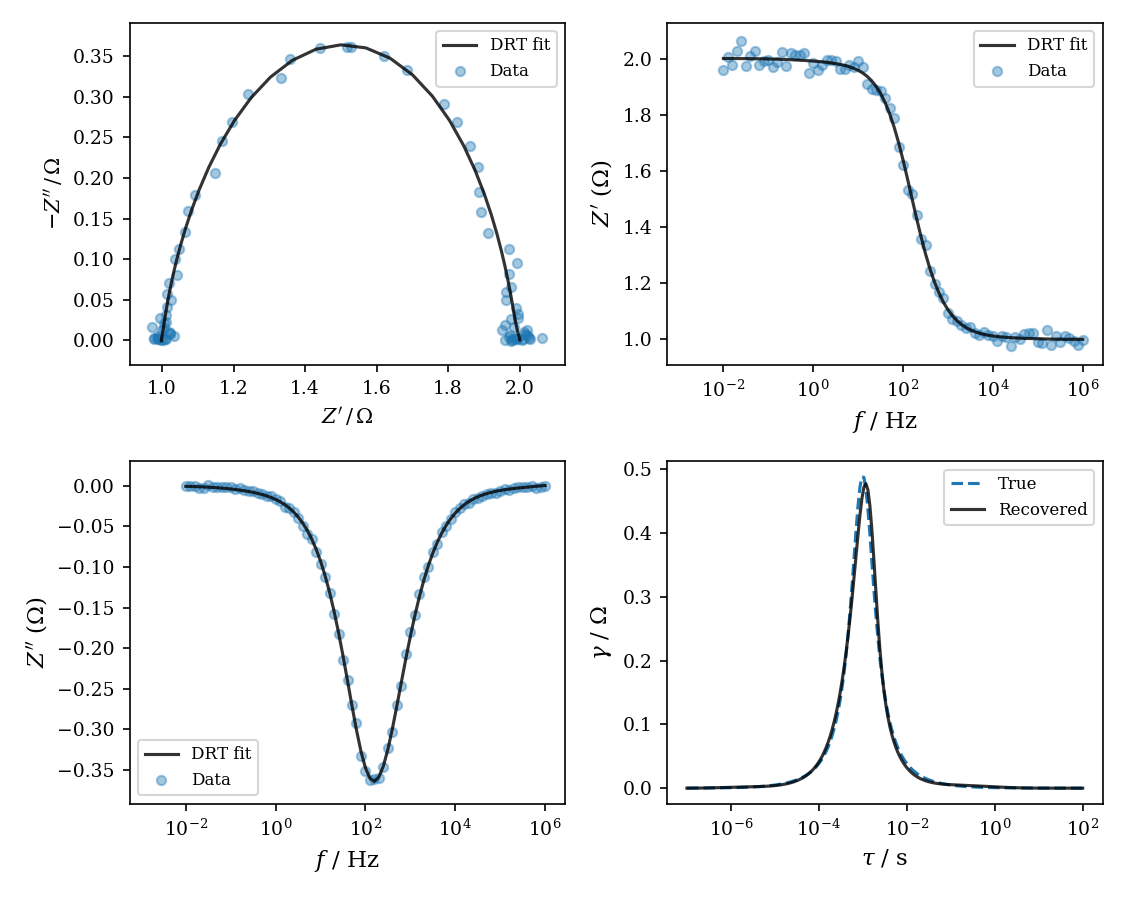

In [58]:
plot_drt_result(dr_ridge,Zdf,g_true)

The figure shows the DRT fit of the impedance data in a Nyquist plot (top left) and Bode plots of the real (top right) and imaginary (bottom left) components of the impedance, as well as the true and recovered DRTs (bottom right). The hyperparametric solution yields a good estimate of the true DRT in this case; the peak is just slightly distorted from the true shape.
## Obtaining the ohmic resistance and inductance
The ohmic resistance and inductance can be accessed through the `coef_` attribute of the `DRT` class. The first entry of `coef_` is the ohmic resistance, the second entry is the inductance, and the remaining entries are the weighting coefficients of the radial basis functions that comprise the estimated DRT.

In [26]:
print('Ohmic resistance = {:.5f} ohms'.format(dr_ridge.coef_[0]))
print('Inductance = {:.5e} H'.format(dr_ridge.coef_[1]))

Ohmic resistance = 0.99801 ohms
Inductance = 2.27049e-10 H


# Hierarchical Bayesian fit via MCMC sampling

Next, we apply the hierarchical Bayesian model and obtain an estimate of the posterior distribution using the Markov Chain Monte Carlo sampler in `Stan`. This approach is accessible via the `bayes_fit` method of the `DRT` class. If you are running your code in a Jupyter notebook, you can monitor sampling progress in the Anaconda Prompt (or other terminal) window.

In [27]:
# sample without obtaining initial parameter estimates from the hyperparametric ridge fit
# copy dr_ridge - A matrices already calculated
dr_mcmc = deepcopy(dr_ridge)
start = time.time()
dr_mcmc.bayes_fit(freq,Zc,init_from_ridge=False)
elapsed = time.time() - start
print('MCMC sampling time (without initial estimates): {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MCMC sampling time (without initial estimates): 59.10 s


<IPython.core.display.Javascript object>


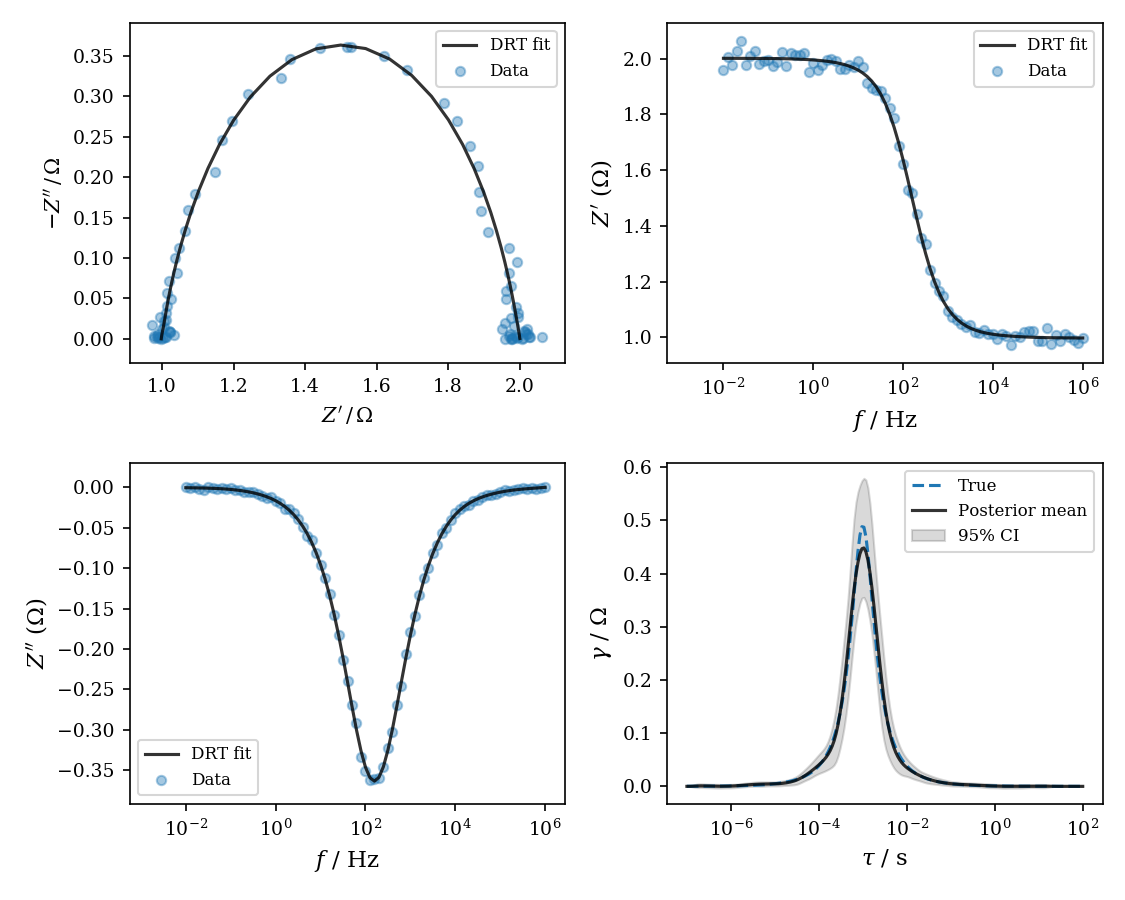

In [28]:
plot_drt_result(dr_mcmc,Zdf,g_true,plot_ci=True)

The solution obtained by MCMC sampling is an estimate of the full posterior distribution; i.e., a distribution of values for each parameter in the model (and $\gamma(\tau)$ at every value of $\tau$). This distribution can be represented by the mean of the posterior distribution, indicated by the black line, and the credibility interval (CI), which indicates in light gray the area between the 2.5th percentile and 97.5th percentile of the posterior distribution. For this spectrum, the peak of the posterior mean is slightly depressed from the true value, but it is not distorted as in the hyperparametric ridge solution. The CI encompasses the true value of the DRT across all $\tau$.

In [29]:
# re-sample, this time providing initial parameter estimates from the hyperparametric ridge fit
dr_mcmc2 = deepcopy(dr_ridge)
start = time.time()
dr_mcmc2.bayes_fit(freq,Zc,init_from_ridge=True)
elapsed = time.time() - start
print('MCMC sampling time (with initial estimates): {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MCMC sampling time (with initial estimates): 62.12 s


<IPython.core.display.Javascript object>


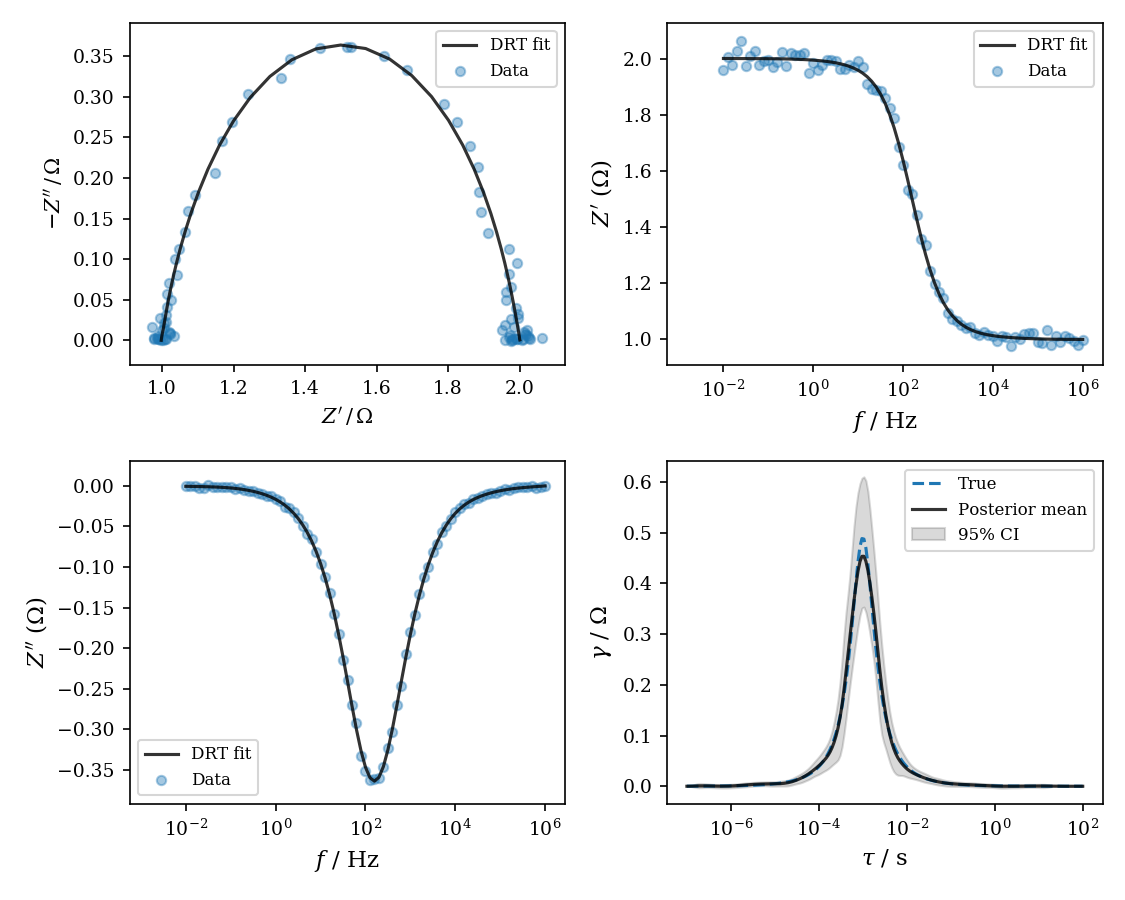

In [30]:
plot_drt_result(dr_mcmc2,Zdf,g_true,plot_ci=True)

The solutions obtained with and without initial parameter estimates are nearly identical, but the sampling runs ~3-12 s faster **without** initial parameter estimates (runtimes vary). For more complex spectra, providing initial estimates generally *reduces* the runtime, in contrast to this scenario.

## Predicting the error structure
The hierarchical Bayesian model also provides estimates of the error structure of the impedance, accessible via the `predit_err_scale` method. The error structure is quantified by the standard deviation (or scale) of the error at each measurement frequency.

<IPython.core.display.Javascript object>


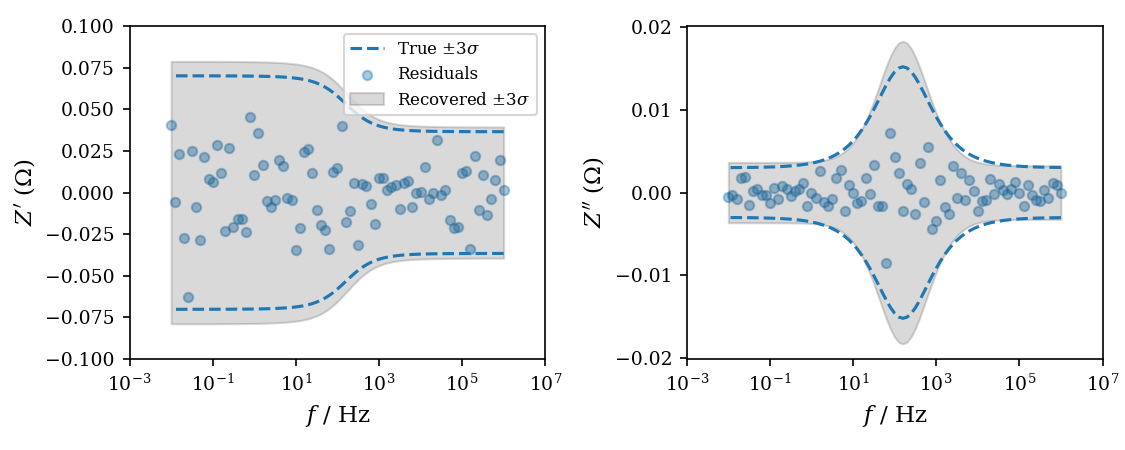

In [46]:
fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# plot residuals
Z_pred = dr_mcmc.predict(freq)
df_err = gt.construct_eis_df(freq,Z_pred-Zc)
gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals')

# plot true error scale
p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())

# get the recovered error scale
sigma_re, sigma_im = dr_mcmc.predict_err_scale(freq)
# plot recovered error scale
axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

axes[0].legend()
#make room for legend
axes[0].set_ylim(-0.1,0.1)
axes[0].set_xlim(1e-3,1e7)

for ax in axes:
    ax.set_xlabel('$f$ / Hz')

The recovered error scale is qualitatively accurate for this spectrum, but slightly overestimates the error level.

# Hierarchical Bayesian fit via MAP optimization
Finally, we obtain a maximum *a posteriori* (MAP) of the DRT by maximizing the hierarchical Bayesian posterior probability using the L-BFGS algorithm implemented in `Stan`. This enables the hierarchical model to be fitted to the data much more quickly than is possible via MCMC sampling. This approach is accessible via the `map_fit` method.

In [50]:
# run MAP optimization without initial parameter estimates
dr_map = deepcopy(dr_ridge)
start = time.time()
dr_map.map_fit(freq,Zc,init_from_ridge=False)
elapsed = time.time() - start
print('MAP optimization time (without initial estimates): {:.2f} s'.format(elapsed))

MAP optimization time (without initial estimates): 1.75 s


<IPython.core.display.Javascript object>


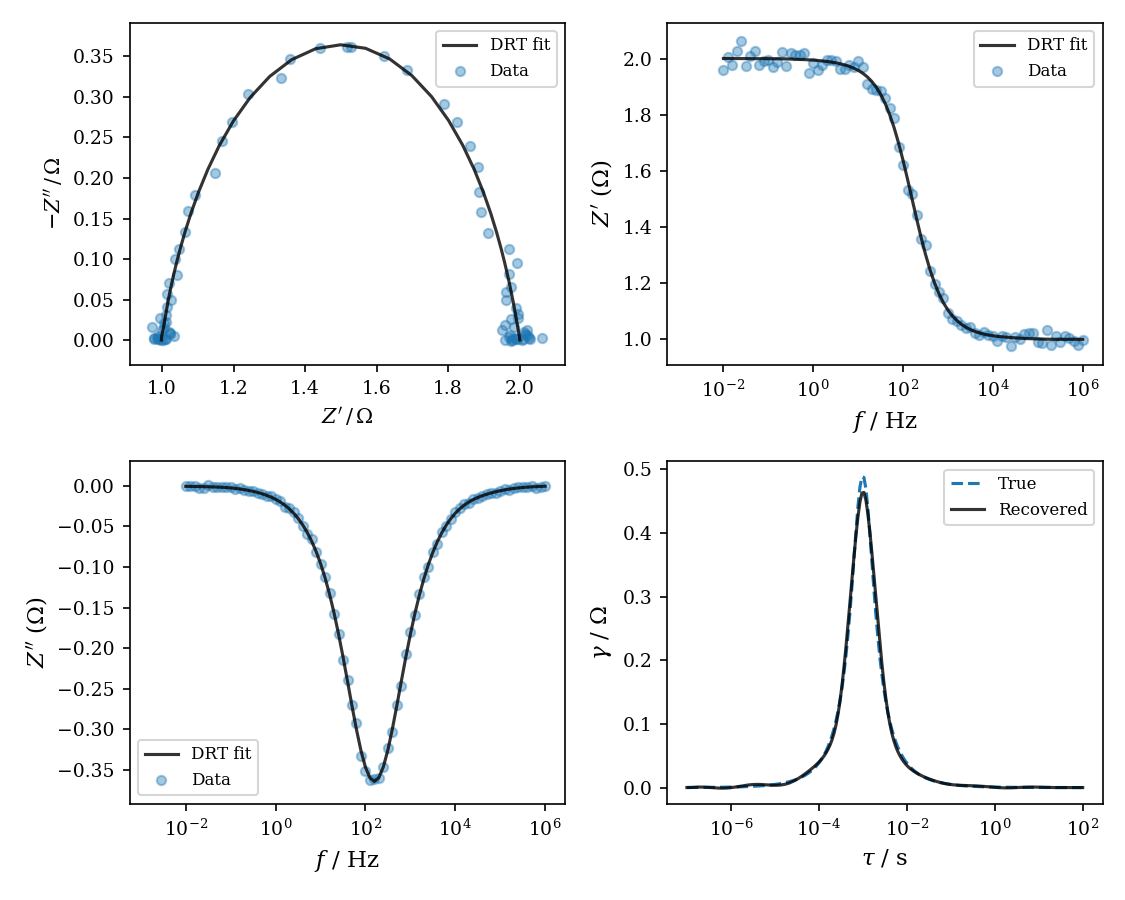

In [51]:
plot_drt_result(dr_map,Zdf,g_true)

The MAP point estimate very closely matches the posterior mean from MCMC sampling.

In [52]:
# run MAP optimization WITH initial parameter estimates
dr_map2 = deepcopy(dr_ridge)
start = time.time()
dr_map2.map_fit(freq,Zc,init_from_ridge=True)
elapsed = time.time() - start
print('MAP optimization time (with initial estimates): {:.2f} s'.format(elapsed))

MAP optimization time (with initial estimates): 2.31 s


<IPython.core.display.Javascript object>


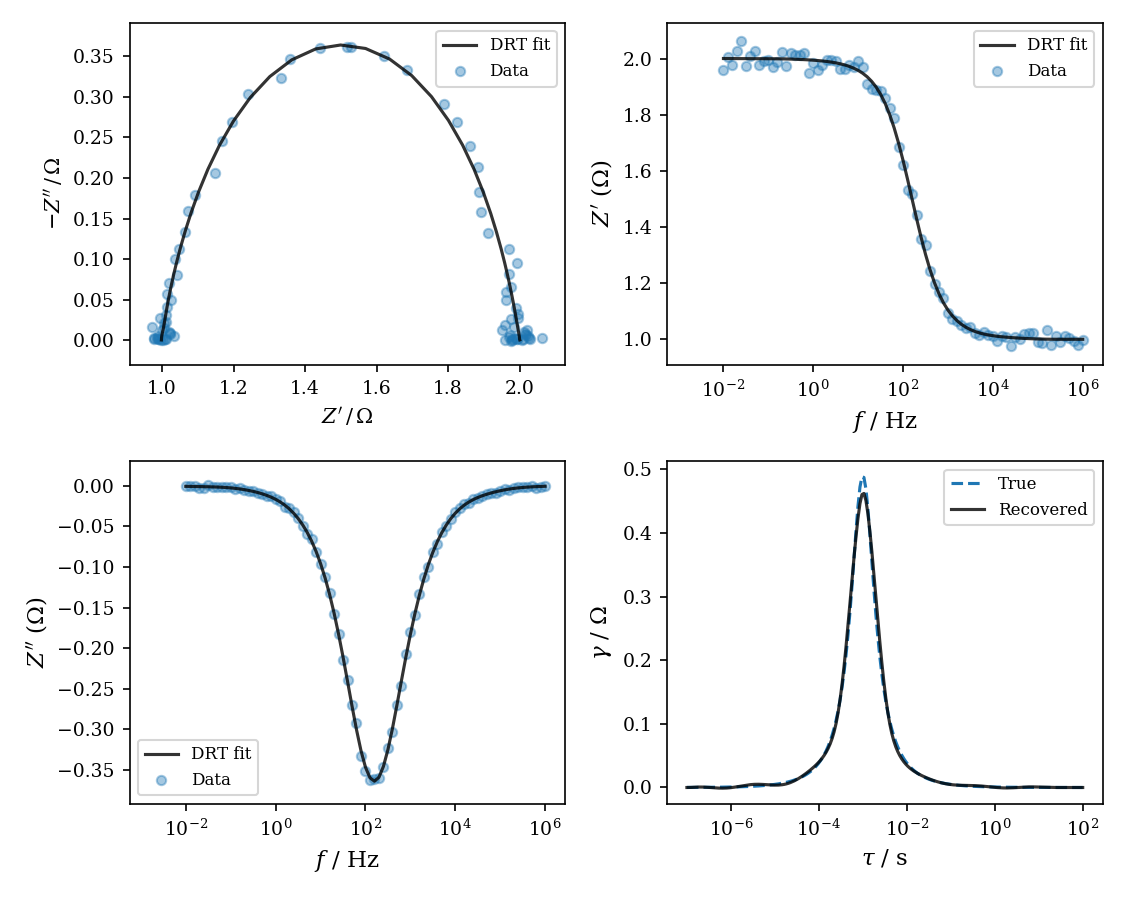

In [53]:
plot_drt_result(dr_map2,Zdf,g_true)

Once again, providing initial parameter estimates from the hyperparametric ridge fit marginally increases the runtime for this spectrum.

Like the MCMC solution, the MAP solution also provides an estimate of the error scale.

<IPython.core.display.Javascript object>


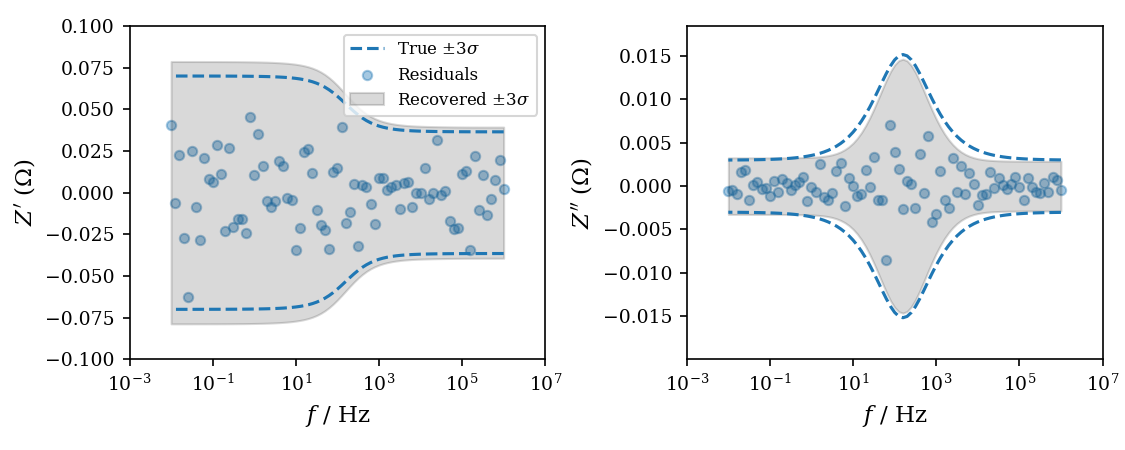

In [55]:
fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# plot residuals
Z_pred = dr_map.predict(freq)
df_err = gt.construct_eis_df(freq,Z_pred-Zc)
gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals')

# plot true error scale
p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())

# get the recovered error scale
sigma_re, sigma_im = dr_map.predict_err_scale(freq)
# plot recovered error scale
axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

axes[0].legend()
#make room for legend
axes[0].set_ylim(-0.1,0.1)
axes[0].set_xlim(1e-3,1e7)

for ax in axes:
    ax.set_xlabel('$f$ / Hz')